In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [5]:
pickle_in = open("../data/nitrate.pickle", "rb")
nitrate = pickle.load(pickle_in)
nitrate.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,NITRATE_VALUE
count,1.319300e+04,1.319300e+04,1.319300e+04,1.319300e+04,1.319300e+04,1.319300e+04,13193.000000
mean,-1.516629e-15,-6.032046e-17,3.446884e-17,3.231453e-17,-1.271038e-15,7.471120e-15,3.982172
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.744430
min,-1.890652e+00,-1.788631e+00,-2.791508e-01,-1.220091e+00,-3.093349e+00,-2.213066e+01,0.020000
25%,-6.959712e-01,-8.599608e-01,-2.791508e-01,-7.283696e-01,-7.209295e-01,-4.641692e-01,0.700000
50%,-5.268161e-02,4.936176e-02,-2.791508e-01,9.212555e-03,-1.211264e-01,8.688615e-02,2.600000
75%,4.987095e-01,8.426006e-01,-2.791508e-01,6.238643e-01,6.143669e-01,5.878456e-01,6.900000
max,3.347563e+00,1.732576e+00,3.810519e+00,6.155730e+00,3.440528e+00,3.186572e+00,25.800000


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [7]:
len(nitrate.index)

13193

In [8]:
nitrate.mean()

Year                 2.222977e-14
Yday                -1.154235e-16
Hour                 3.668406e-14
PRESSURE            -5.591424e-16
TEMPERATURE_VALUE   -1.224553e-15
SALINITY_VALUE       7.180239e-15
NITRATE_VALUE        3.982172e+00
dtype: float64

In [4]:
## Train test split
train_dataset = nitrate.sample(frac=0.8, random_state=0)
test_dataset  = nitrate.drop(train_dataset.index)

In [5]:
train_labels = train_dataset.pop('NITRATE_VALUE')
test_labels = test_dataset.pop('NITRATE_VALUE')

In [11]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
8358,0.039217,-0.521383,-0.279151,-0.482509,1.197749,0.061838
13195,0.866304,-0.743877,-0.279151,-0.236648,1.603956,1.502096
10712,0.314912,1.200525,-0.279151,-1.220091,0.566832,0.118196
15413,3.255665,-0.714856,3.810519,0.623864,1.028784,0.475130
376,-1.706855,0.455655,-0.279151,-0.974230,-0.569682,0.362414


### The Model

In [6]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [7]:
model = build_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[0.13360588],
       [0.36526144],
       [0.07536654],
       [0.83241576],
       [0.02010188],
       [0.16854614],
       [0.15300976],
       [0.13701682],
       [0.3569321 ],
       [0.10873897]], dtype=float32)

In [9]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [10]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.300617,1.031421,2.300617,97.939332,2.423376,1.063462,2.423376,105.105243
std,0.570878,0.104052,0.570878,9.939760,0.163127,0.055043,0.163127,15.410430
min,1.987997,0.957157,1.987997,89.729683,2.246298,1.003301,2.246299,82.564362
25%,2.069382,0.975136,2.069382,91.768568,2.318255,1.023278,2.318255,92.907480
50%,2.190808,1.003269,2.190808,94.768066,2.376198,1.048523,2.376198,101.762177
75%,2.380598,1.060072,2.380599,100.817736,2.493089,1.088011,2.493089,112.977184
max,7.488298,1.849109,7.488298,162.262695,3.314880,1.320765,3.314880,155.972656


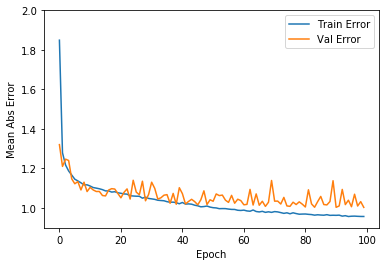

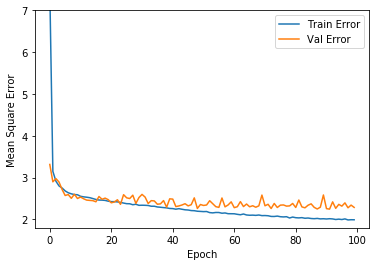

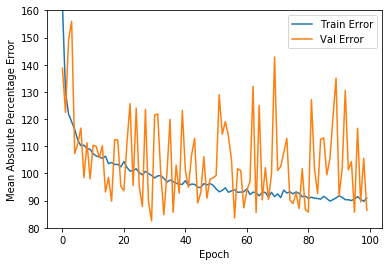

In [11]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [31]:
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

2639/2639 - 0s - loss: 2.4043 - mae: 1.0691 - mse: 2.4043 - mean_absolute_percentage_error: 117.4726
Testing set Mean Abs Percentage Error: 117.47
